# Retirement Model
The goal of this notebook is to model retirement. In particular, trying to understand the principal needed for retirement and the strategy throughout requirement to maintain capital.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## S&P 500
This models the S&P 500 on an annual basis. This is intended for a long term simulation.

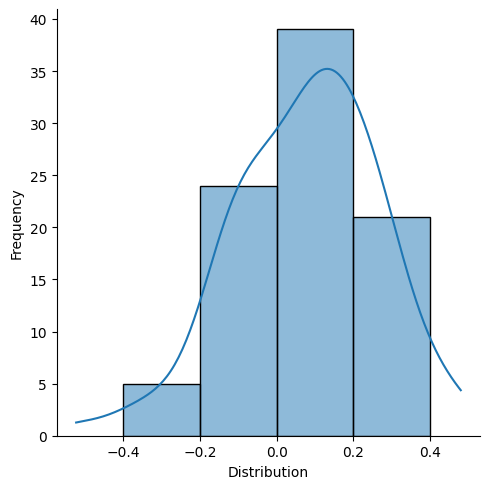

In [3]:
spx = pd.read_csv("https://raw.githubusercontent.com/harlepengren/DataAnalysis/main/data/SPX_annual.csv")
ax = sns.displot(spx["Change"],bins=[-0.4,-0.2,0,0.2,0.4],kde=True)
ax.set(xlabel='Distribution', ylabel='Frequency')

In [4]:
print("Mean:",np.mean(spx["Change"]))
print("Median:",np.median(spx["Change"]))
print("Skew:",scipy.stats.skew(spx["Change"]))

Mean: 0.07597956989247312
Median: 0.0944
Skew: -0.4022425580246638


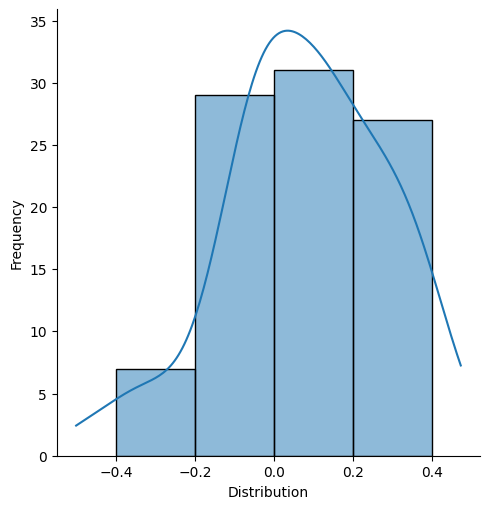

In [5]:
spx_stats = scipy.stats.skewnorm.fit(spx["Change"])
sample = scipy.stats.skewnorm(spx_stats[0],spx_stats[1],spx_stats[2]).rvs(100)
ax = sns.displot(sample,bins=[-0.4,-0.2,0,0.2,0.4],kde=True)
ax.set(xlabel='Distribution', ylabel='Frequency')

## S&P 500 Dividends
Models the dividend yield.

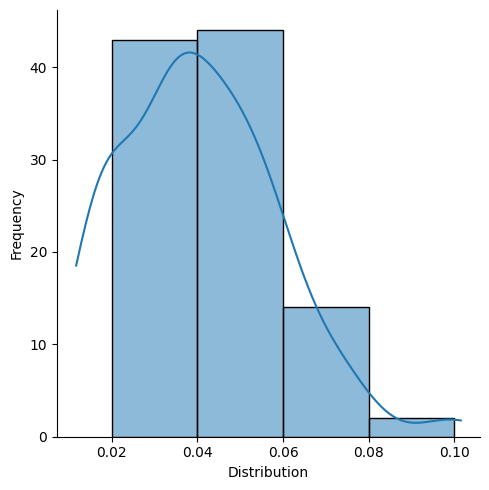

In [6]:
dividend = pd.read_csv("https://raw.githubusercontent.com/harlepengren/DataAnalysis/main/data/SPX%20Yield.csv")
dividend["Yield"] = dividend["Yield"].str.rstrip('%').astype('float')/100.0
ax = sns.displot(dividend["Yield"],bins=[0.02,0.04,0.06,0.08,0.1],kde=True)
ax.set(xlabel='Distribution', ylabel='Frequency')
plt.show()

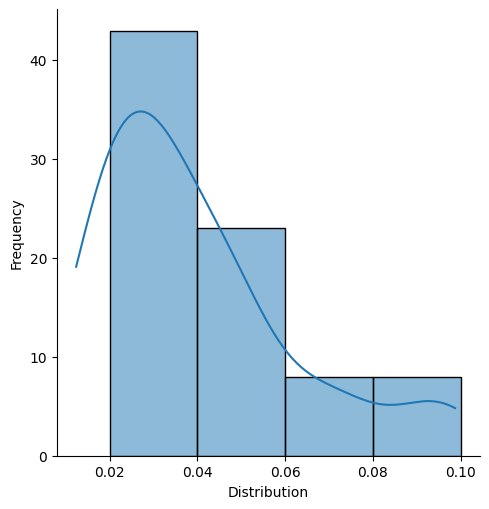

In [7]:
dividend_stats = scipy.stats.skewnorm.fit(dividend["Yield"])
div_sample = scipy.stats.skewnorm(dividend_stats[0],dividend_stats[1],dividend_stats[2]).rvs(100)
ax = sns.displot(div_sample,bins=[0.02,0.04,0.06,0.08,0.1],kde=True)
ax.set(xlabel='Distribution', ylabel='Frequency')

## Stock Model

This is a class that allows us to handle basic stock operations  (buy, sell, change price).

In [8]:
class Stock:
  def __init__(self, ticker:str, price:float, num_shares:float, dividend:float):
    """Initialize the stock:
    ticker: stock ticker (e.g., voo)
    price: price per share
    num_shares: number of shares (note this is float to allow fractional shares)
    dividend: *annual* dividend"""
    self.ticker = ticker
    self.price = price
    self.num_shares = num_shares
    self.dividend = dividend
    self.cost_basis = price

  def pay_dividend(self)->float:
    return self.dividend * self.num_shares

  def buy_amount(self, amount:float):
    """Used if you have a specific currency amount of stock you
    want to buy."""
    self.num_shares += amount/self.price

  def buy_shares(self, num_shares:float):
    self.num_shares += num_shares

  def sell_shares(self, num_shares:float)->float:
    max_shares = min(num_shares,self.num_shares)
    self.num_shares -= max_shares
    return max_shares * self.price

  def sell_amount(self, amount:float)->float:
    """Used if you have a specific currency amount of stock you
    want to sell."""
    sell_shares = amount/self.price
    total_shares = min(self.num_shares,sell_shares)
    income = total_shares * self.price
    self.num_shares -= total_shares

    return income

  def change_dividend(self, percent:float):
    """Change the dividend by a given percentage."""
    self.dividend *= (1 + percent)

  def change_price(self, percent:float):
    """Change the price by a given percentage."""
    self.price *= (1+percent)
    self.change = percent

  def __str__(self):
    return "Price: " + str(self.price) + "\nShares: " + str(self.num_shares) + "\nDividend: " + str(self.dividend) + "\nTotal: " + str(self.price * self.num_shares)

Next is a model to simulate the stock market over the longer term.

In [9]:
# Tax rates
ordinary_tax_rate = 0.3
capital_tax_rate = 0.2

class Model:
  """Basic parent model class."""
  def __init__(self):
    self.holdings = []

  def add(self, new_holding):
    self.holdings.append(new_holding)

  def run_model(self):
    raise NotImplementedError

class StockModel(Model):
  def __init__(self):
    self.spx = pd.read_csv("https://raw.githubusercontent.com/harlepengren/DataAnalysis/main/data/SPX_annual.csv")
    self.dividend = pd.read_csv("https://raw.githubusercontent.com/harlepengren/DataAnalysis/main/data/SPX%20Yield.csv")
    self.dividend["Yield"] = self.dividend["Yield"].str.rstrip('%').astype('float')/100.0
    self.stock_stats = scipy.stats.skewnorm.fit(self.spx["Change"])
    self.dividend_stats = scipy.stats.skewnorm.fit(self.dividend["Yield"])

    super().__init__()

  # Test whether this is generating accurate stock numbers
  def basic_test(self,stock_price:float,num_shares:float,years:int)->float:
    """Test whether the model is generating accurate stock numbers."""
    price_list = []
    stock = Stock("test",stock_price,num_shares,0)
    self.add(stock)
    for index in range(years):
      self.run_model()
      price_list.append(self.get_net_worth())

    return price_list

  def get_net_worth(self)->float:
    value = 0

    for current_stock in self.holdings:
      value += current_stock.num_shares * current_stock.price

    return value

  def get_dividend(self)->float:
    total_dividend = 0

    for current_stock in self.holdings:
      total_dividend += current_stock.dividend

    return total_dividend

  def get_stock_change(self)->float:
    return self.stock_change

  def get_dividend_change(self)->float:
    return self.dividend_change

  def run_model(self)->float:
    # Update the stock value
    self.stock_change = scipy.stats.skewnorm(self.stock_stats[0],self.stock_stats[1],self.stock_stats[2]).rvs()
    self.dividend_change = scipy.stats.skewnorm(self.dividend_stats[0],self.dividend_stats[1],self.dividend_stats[2]).rvs()

    income = 0
    for current_stock in self.holdings:
        current_stock.change_price(self.stock_change)
        current_stock.change_dividend(self.dividend_change)
        income += current_stock.pay_dividend()
        #income -= income*capital_tax_rate

    return round(income,2)

Compare the results of our model to a random stock period.

Date selected: 1/2/45
Stock price: 13.33


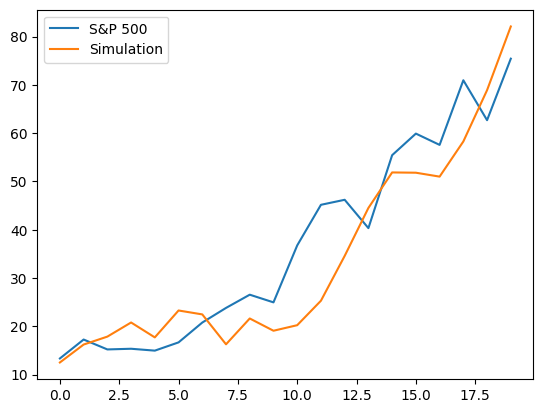

[12.497632448532315, 16.21018739762584, 17.854797868059833, 20.781758724642366, 17.6961094645875, 23.26676632854017, 22.456287192501875, 16.260870461871907, 21.61202446233759, 19.072833452942522, 20.22155594910452, 25.292806407505584, 34.57336010126303, 44.51149289300728, 51.86401532252254, 51.807626362903356, 50.99798067298262, 58.27625161018545, 68.91129870283814, 82.10081656205149]


In [10]:
comparison_period = 20 # years
# Pick a random year from the stock data. Since we are going to simulate across 10 years,
# we need to select from anything except the last 10 years.
comparison_date = spx[:-comparison_period].sample()
starting_price = comparison_date["Close"].values[0]
index = comparison_date.index.values[0]
comparison = spx.iloc[index:index+comparison_period]
print("Date selected:",comparison_date["Date"].values[0])
print("Stock price:", starting_price)


stocks = StockModel()
data = stocks.basic_test(starting_price,1,comparison_period)

plt.plot(range(comparison_period),comparison["Close"],label="S&P 500")
plt.plot(range(comparison_period),data,label="Simulation")
plt.legend()
plt.show()
print(data)

Run many times to see whether results are close.

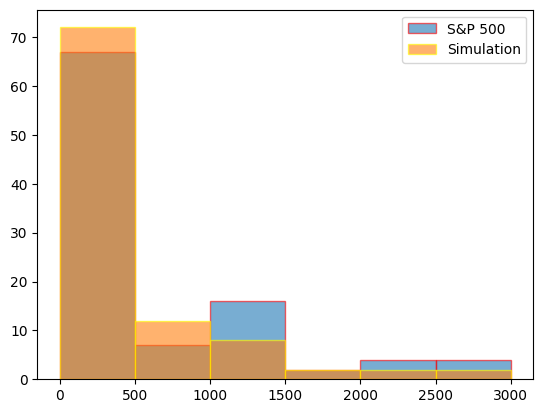

      S&P 500 Simulation
Mean: 570.59 738.77
Median: 122.74 220.63


In [11]:
iterations = 100
comparison_period = 20 # years

spx_results = []
sim_results = []
for _ in range(iterations):
  # Pick a random year from the stock data. Since we are going to simulate across 10 years,
  # we need to select from anything except the last 10 years.
  comparison_date = spx[:-comparison_period].sample()
  starting_price = comparison_date["Close"].values[0]
  index = comparison_date.index.values[0]
  comparison = spx.iloc[index:index+comparison_period]
  spx_results.append(comparison.iloc[-1:]["Close"].values[0])


  stocks = StockModel()
  sim_results.append(stocks.basic_test(starting_price,1,comparison_period)[-1:][0])

plt.hist(spx_results,bins=[0,500,1000,1500,2000,2500,3000],label="S&P 500",alpha=0.6,edgecolor="red")
plt.hist(sim_results,bins=[0,500,1000,1500,2000,2500,3000],label="Simulation",alpha=0.6,edgecolor="yellow")
plt.legend()
plt.show()

print("     ","S&P 500","Simulation")
print("Mean:",round(np.mean(spx_results),2),round(np.mean(sim_results),2))
print("Median:",round(np.median(spx_results),2),round(np.median(sim_results),2))

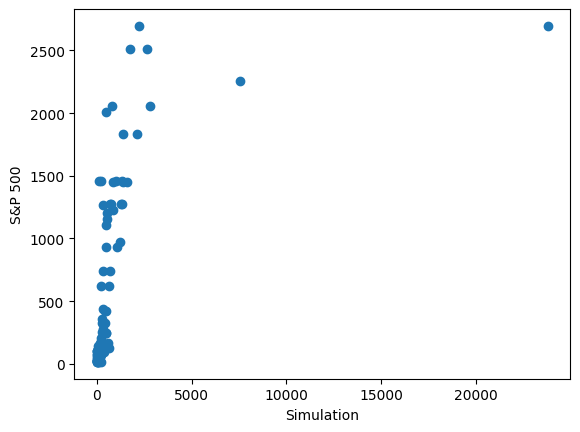

In [16]:
plt.scatter(sim_results,spx_results)
plt.xlabel("Simulation")
plt.ylabel("S&P 500")
plt.show()

In [17]:
# Outliers
print(sorted(sim_results)[-5:])

[2241.760373133709, 2630.1692907921347, 2782.158327399557, 7533.47110308521, 23790.40941879483]


Overall, the simulation gives good results with the exception of a few outliers.